# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

**Point to note**
- The original dataset has no missing values

The two notes are:
G# (G sharp)
Ab (A flat)

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler


def data_clean(features_df):
    category_features = features_df.dtypes[features_df.dtypes == 'object'].index.tolist()
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(features_df[category_features])

    encoded_feature_names = encoder.get_feature_names_out(category_features)
    encoded_data_frame = pd.DataFrame(encoded_data, columns=encoded_feature_names)

    # combine features back together
    transformed_data = pd.concat([features_df.drop(columns=category_features), encoded_data_frame], axis=1)

    # Remove # tags from feature names
    for item in transformed_data.columns:
        if "#" in item:
            transformed_data.rename(columns={item: item.split("#/")[0] + "_sharp"}, inplace=True)
            
    # Remove Correlating features
    corr = transformed_data.corr()
    correlating_feature_pair_list = corr[(corr > 0.30) & (corr < 1.0)].stack().index.tolist()
    for item in range(0, len(correlating_feature_pair_list)):
        if item % 2 == 0:
            transformed_data.drop(columns=[correlating_feature_pair_list[item][0]], axis=1, inplace=True)

    return transformed_data

# Transform the data to deal with outliers
def outliers_deal(data):
    data_to_transform = data.copy()
    outliers = data_to_transform.skew().sort_values(ascending=False)
    outlier_column = outliers.loc[outliers > 0.75]
    for col in outlier_column.index:
        data_to_transform[col] = np.sqrt(data_to_transform[col])
    
    return data_to_transform

pd_DF = pd.read_csv('data/spotify_top_songs_audio_features.csv')
pd_DF.drop(columns=['track_name', "artist_names", "id", "source"], axis=0, inplace=True)
training_data = data_clean(pd_DF)
training_data = outliers_deal(training_data)
training_data.describe()


,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,streams,key_A,key_A_sharp,key_B,...,key_F,key_F_sharp,key_G,key_G_sharp,mode_Major,mode_Minor,time_signature_1,time_signature_3 beats,time_signature_4 beats,time_signature_5 beats
count,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,...,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000
mean,0.319674,0.416701,0.029476,0.402037,122.117244,446.916111,7786.375070,0.080454,0.071396,0.087057,...,0.081529,0.076923,0.091356,0.084907,0.575311,0.424689,0.003838,0.049747,0.929986,0.016429
std,0.140516,0.251259,0.107711,0.136151,29.416097,53.226959,6953.021432,0.272016,0.257504,0.281940,...,0.273667,0.266490,0.288136,0.278765,0.494334,0.494334,0.061841,0.217438,0.255190,0.127127
min,0.152315,0.002744,0.000000,0.140357,46.718000,173.588594,1589.074888,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.209762,0.210713,0.000000,0.312090,98.007000,415.978365,2948.738713,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.268701,0.380789,0.000000,0.352136,120.034000,445.384104,5208.508136,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.403733,0.596657,0.006372,0.467974,142.025000,475.397728,9975.698321,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,0.982853,0.996995,0.976217,0.988433,212.117000,831.102882,59400.759120,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Principal Component Analysis

Text(0.5, 1.0, 'Explained Variance vs Number of Components')

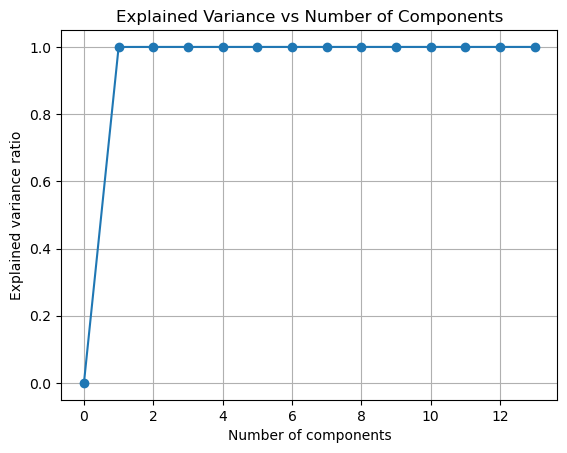

In [40]:
from sklearn.decomposition import PCA
values = np.arange(14)
n_components_explained_variance = []
for item in values:
    pca = PCA(n_components=item) # return top 2 eigenVectors
    pca.fit_transform(training_data)
    n_components_explained_variance.append(pca.explained_variance_ratio_.sum())

plt.grid()
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.plot(values,n_components_explained_variance,marker="o")
plt.title("Explained Variance vs Number of Components")


# Finding Optimum number of clusters

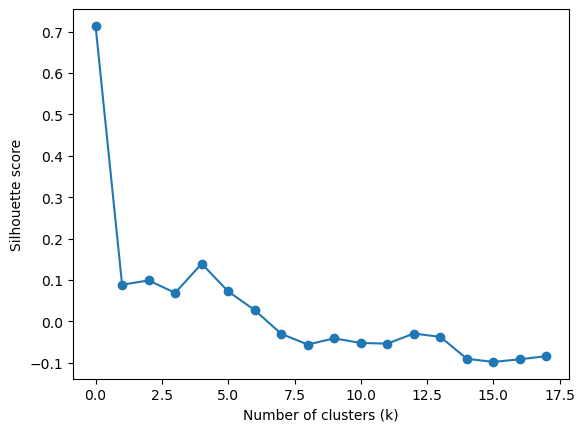

In [49]:
pca_transformed_df = PCA(n_components=2).fit_transform(training_data)
pca_transformed_df = pd.DataFrame(pca_transformed_df,columns=['PC1','PC2'])


pipeline = Pipeline([
    ("scaler", RobustScaler()), ("kmeans", KMeans(n_clusters=2, random_state=42))
])
pipeline.fit(pca_transformed_df)
pca_transformed_df['Cluster'] = pipeline.named_steps['kmeans'].labels_

silhouettes = []
for i in list(range(1, 20)):
    pipeline = Pipeline([
        ("scaler", RobustScaler()), ("kmeans", KMeans(n_clusters=i, random_state=42))
    ])
    pipeline.fit(pca_transformed_df)
    if i != 1:
        silhouettes.append(silhouette_score(training_data, pipeline.named_steps['kmeans'].labels_))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.plot(silhouettes, marker='o')
# 
# plt.scatter(pca_transformed_df['PC1'], pca_transformed_df['PC2'], c=pca_transformed_df['Cluster'])
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('K-means Clustering on PCA-Transformed Data')
# plt.show()# inertia = []

# labels = pipeline.named_steps["kmeans"].labels_

# Clustering with optimum value

In [189]:
pipeline = Pipeline([
    ("scaler", RobustScaler()), ("kmeans", KMeans(n_clusters=14, random_state=42))
])
pipeline.fit(data_pre_transformation)
print(silhouette_score(data_pre_transformation, pipeline.named_steps['kmeans'].labels_))

-0.15292552308240273
